## Connect to ElasticSearch

In [1]:
from pprint import pprint
from elasticsearch import Elasticsearch

es = Elasticsearch('http://localhost:9200')
client_info = es.info()
print('Connected to Elasticsearch!')
pprint(client_info.body)

Connected to Elasticsearch!
{'cluster_name': 'docker-cluster',
 'cluster_uuid': 'FQt-ffZfTpeh0Snf3pUAQw',
 'name': 'ae8b5b4be42b',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2024-08-05T10:05:34.233336849Z',
             'build_flavor': 'default',
             'build_hash': '1a77947f34deddb41af25e6f0ddb8e830159c179',
             'build_snapshot': False,
             'build_type': 'docker',
             'lucene_version': '9.11.1',
             'minimum_index_compatibility_version': '7.0.0',
             'minimum_wire_compatibility_version': '7.17.0',
             'number': '8.15.0'}}


## Get Documents

In [2]:
count = es.count(index="cpu_example_template")
pprint(count.body)

{'_shards': {'failed': 0, 'skipped': 0, 'successful': 1, 'total': 1},
 'count': 770}


In [3]:
response = es.search(
    index="cpu_example_template",
    body={
        "query":{
            "match_all":{}
        },
        "size":1000,
    },
)

hits = response.body['hits']['hits']
print(f"Found {len(hits)} documents")    

Found 770 documents


## Plot the time series data

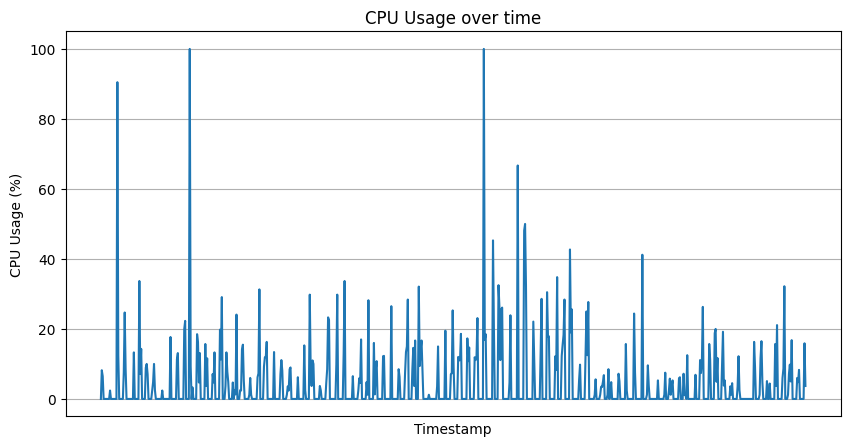

In [4]:
import matplotlib.pyplot as plt

cpu_usage_values = [hit["_source"]["cpu_usage"] for hit in hits]
timestamp_values = [hit["_source"]["@timestamp"] for hit in hits]

plt.figure(figsize=(10, 5))
plt.plot(timestamp_values, cpu_usage_values)
plt.xticks([])
plt.xlabel("Timestamp")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage over time")
plt.grid(True)
plt.show()

## Aggregations

In [5]:
response = es.search(
    index="cpu_example_template",
    body={
        "aggs": {
            "avg_cpu_usage": {
                "avg" : {
                    "field":"cpu_usage",
                }
            }
        }
    }
)

average_cpu_usage = response.body["aggregations"]["avg_cpu_usage"]["value"]
print(f"Average CPU usage: {average_cpu_usage}%")

Average CPU usage: 4.292067664362801%


In [6]:
response = es.search(
    index="cpu_example_template",
    body={
        "aggs": {
            "max_cpu_usage": {
                "max": {
                    "field": "cpu_usage"
                }
            }
        },
    },
)
max_cpu_usage = response.body["aggregations"]["max_cpu_usage"]["value"]
print(f"Max CPU usage: {max_cpu_usage}%")

Max CPU usage: 100.0%


## Monitoring the index lifecycle

In [7]:
response = es.indices.get_data_stream()
pprint(response.body)

{'data_streams': [{'_meta': {'description': 'Templatefor CPU usage data'},
                   'allow_custom_routing': False,
                   'generation': 3,
                   'hidden': False,
                   'ilm_policy': 'cpu_usage_policy_v2',
                   'indices': [{'ilm_policy': 'cpu_usage_policy_v2',
                                'index_name': '.ds-cpu_example_template-2025.11.05-000002',
                                'index_uuid': '4lfGQfsMR5q0LQtqtil5-Q',
                                'managed_by': 'Index Lifecycle Management',
                                'prefer_ilm': True}],
                   'name': 'cpu_example_template',
                   'next_generation_managed_by': 'Index Lifecycle Management',
                   'prefer_ilm': True,
                   'replicated': False,
                   'rollover_on_write': False,
                   'status': 'YELLOW',
                   'system': False,
                   'template': 'cpu_example_template'

In [8]:
ilm_status = es.ilm.get_lifecycle(name="cpu_usage_policy_v2")
pprint(ilm_status.body)

{'cpu_usage_policy_v2': {'in_use_by': {'composable_templates': ['cpu_example_template'],
                                       'data_streams': ['cpu_example_template'],
                                       'indices': ['.ds-cpu_example_template-2025.11.06-000006',
                                                   '.ds-cpu_example_template-2025.11.06-000004']},
                         'modified_date': '2025-11-05T09:28:10.089Z',
                         'policy': {'phases': {'delete': {'actions': {'delete': {'delete_searchable_snapshot': True}},
                                                          'min_age': '20m'},
                                               'hot': {'actions': {'rollover': {'max_age': '5m'}},
                                                       'min_age': '0ms'}}},
                         'version': 1}}


In [9]:
response = es.ilm.explain_lifecycle(
    index=".ds-cpu_example_template*")
pprint(response.body)

{'indices': {'.ds-cpu_example_template-2025.11.06-000004': {'action': 'complete',
                                                            'action_time_millis': 1762420017319,
                                                            'age': '18.25m',
                                                            'index': '.ds-cpu_example_template-2025.11.06-000004',
                                                            'index_creation_date_millis': 1762417617322,
                                                            'lifecycle_date_millis': 1762420017319,
                                                            'managed': True,
                                                            'phase': 'hot',
                                                            'phase_execution': {'modified_date_in_millis': 1762334890089,
                                                                                'phase_definition': {'actions': {'rollover': {'max_age': '5m',
      